In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import getpass
user = getpass.getuser()

In [3]:
from PIL import Image

In [4]:
from omni.isaac.kit import SimulationApp

# "/home/yizhou/Research/OpenAnyDrawer/scene0.usd" # 
usd_path = f"omniverse://localhost/Users/{user}/scene4.usd"


simulation_app = SimulationApp({"headless": True, "open_usd": usd_path,  "livesync_usd": usd_path}) 


Starting kit application with the fillowing args:  ['/home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/exts/omni.isaac.kit/omni/isaac/kit/simulation_app.py', '/home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/apps/omni.isaac.sim.python.kit', '--/app/tokens/exe-path=/home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--ext-folder', '/home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/exts', '--ext-folder', '/home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/apps', '--portable', '--no-window']
Passing the following args to the base kit application:  ['-f', '/home/yizhou/.local/share/jupyter/runtime/kernel-b3cb4439-d21b-45ef-bab7-f0a392104ea9.json

OmniAssetFileFormat
2022-08-18 23:33:08 [3,180ms] [Error] [rtx.neuraylib.plugin] [DYNLIB:IO]   0.1   DYNLIB io   error: /home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/kit/python/bin/libs/iray/libnvindex.so: cannot open shared object file: No such file or directory
2022-08-18 23:33:08 [3,180ms] [Error] [rtx.neuraylib.plugin] [INDEX:MAIN]   0.1   INDEX  main error: Failed to load /home/yizhou/.local/share/ov/pkg/isaac_sim-2022.1.0/kit/python/bin/libs/iray/libnvindex.so


[2.581s] [ext: omni.mdl-0.1.0] startup
[2.617s] [ext: omni.kit.menu.create-1.0.2] startup
[2.619s] [ext: omni.kit.window.file_exporter-1.0.4] startup
[2.622s] [ext: omni.kit.window.drop_support-1.0.0] startup
[2.624s] [ext: omni.kit.material.library-1.3.10] startup
[2.629s] [ext: omni.kit.window.property-1.6.3] startup
[2.633s] [ext: omni.kit.context_menu-1.3.9] startup
[2.641s] [ext: omni.kit.window.file_importer-1.0.4] startup
[2.643s] [ext: omni.kit.stage_templates-1.1.2] startup
[2.647s] [ext: omni.kit.widget.stage-2.6.15] startup
[2.655s] [ext: omni.kit.window.file-1.3.16] startup
[2.659s] [ext: omni.debugdraw-0.1.0] startup
[2.670s] [ext: omni.kit.window.content_browser-2.4.28] startup
[2.690s] [ext: omni.kit.widget.prompt-1.0.1] startup
[2.691s] [ext: omni.kit.property.usd-3.14.8] startup
[2.761s] [ext: omni.hydra.engine.stats-1.0.0] startup
[2.772s] [ext: omni.kit.widget.settings-1.0.0] startup
[2.775s] [ext: omni.graph.tools-1.3.5] startup
[2.879s] [ext: omni.graph.core-2.27.0

In [5]:
# world
from omni.isaac.core import World
world = World()

In [6]:
# reset scene
import omni
mobility_prim = world.scene.stage.GetPrimAtPath("/World/Game/mobility")
if mobility_prim:
    omni.kit.commands.execute("DeletePrims", paths=["/World/Game/mobility"])
    
# hide robot
# hand_prim = world.scene.stage.GetPrimAtPath("/World/allegro")
# hand_prim.GetAttribute('visibility').Set('invisible')

In [7]:
from open_env import OpenEnv

env = OpenEnv()

In [8]:
from franka.gripper import GripperHandEnv

# env = HandEnv("/World/Hand/Bones/l_carpal_mid", "/World/Hand*/Bones/l_thumbSkeleton_grp/l_distalThumb_mid")
controller = GripperHandEnv("/World/Franka/panda_link8", "/World/AnchorXform")

In [9]:
env.add_camera()
env.setup_viewport()

simlation context numpy None
num_envs 1


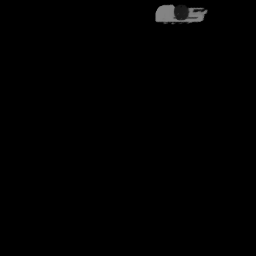

In [10]:
# init
world.reset()
controller.start()
world.scene.add(controller.robots)

world.render()
env.get_image()

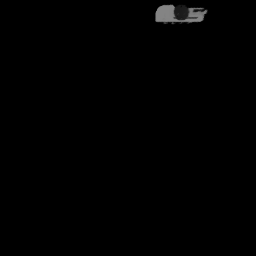

In [11]:
world.render()
env.get_image()

In [27]:
env.add_object(0, scale = 0.1)

add object
loading asset from omni nucleus
physics material: path:  /World/Game/mobility/link_0/visuals/handle_7/physicsMaterial
add physics material to handle


In [13]:
from omni.isaac.core.prims.xform_prim import XFormPrim
mobility_obj = XFormPrim("/World/Game/mobility")
mobility_obj_name = mobility_obj.name

world.scene.add(mobility_obj)

In [14]:
from task.checker import TaskChecker
from task.instructor import SceneInstructor

In [15]:
scene_instr = SceneInstructor()
scene_instr.analysis()

analysis_spatial_rel:  {'/World/Game/mobility/link_0/visuals/handle_7': {'joint_type': 'PhysicsRevoluteJoint', 'cabinet_type': 'door', 'vertical_description': '', 'horizontal_description': '', 'joint': 'joint_0', 'relative_to_game_center': 'right', 'direction': 'horizontal'}}


In [16]:
scene_instr.is_obj_valid

True

In [17]:
scene_instr.valid_handle_list

{'/World/Game/mobility/link_0/visuals/handle_7': {'joint_type': 'PhysicsRevoluteJoint',
  'cabinet_type': 'door',
  'vertical_description': '',
  'horizontal_description': '',
  'joint': 'joint_0',
  'relative_to_game_center': 'right',
  'direction': 'horizontal'}}

In [18]:
handle_path_str = list(scene_instr.valid_handle_list.keys())[0]

handle_joint_type = scene_instr.valid_handle_list[handle_path_str]["joint_type"]
handle_joint = scene_instr.valid_handle_list[handle_path_str]["joint"]
handle_rel_direciton = scene_instr.valid_handle_list[handle_path_str]["relative_to_game_center"]
handle_direction = scene_instr.valid_handle_list[handle_path_str]["direction"]

In [19]:
handle_path_str, handle_joint_type, handle_joint, handle_rel_direciton

('/World/Game/mobility/link_0/visuals/handle_7',
 'PhysicsRevoluteJoint',
 'joint_0',
 'right')

In [20]:
task_checker = TaskChecker("mobility", handle_joint, handle_joint_type, IS_RUNTIME=True)

11.484s] [ext: omni.kit.widget.live-0.1.0] startup
[11.495s] [ext: omni.isaac.surface_gripper-0.1.2] startup
[11.506s] [ext: omni.kit.property.layer-1.1.2] startup
[11.510s] [ext: omni.isaac.range_sensor-0.4.2] startup
[11.562s] [ext: omni.graph.window.generic-1.3.8] startup
[11.566s] [ext: omni.isaac.utils-0.1.11] startup
[11.575s] [ext: omni.isaac.universal_robots-0.2.1] startup
[11.577s] [ext: omni.kit.property.audio-1.0.5] startup
[11.581s] [ext: omni.kit.property.skel-1.0.1] startup
[11.585s] [ext: omni.kit.property.render-1.1.0] startup
[11.587s] [ext: omni.kit.property.camera-1.0.3] startup
[11.590s] [ext: omni.kit.property.geometry-1.2.0] startup
[11.596s] [ext: omni.kit.property.light-1.0.5] startup
[11.601s] [ext: omni.kit.property.transform-1.0.2] startup
[11.608s] [ext: omni.isaac.occupancy_map-0.2.4] startup
[11.633s] [ext: omni.ui.scene-1.4.6] startup
[11.648s] [ext: omni.kit.window.console-0.2.0] startup
[11.660s] [ext: omni.kit.window.status_bar-0.1.1] startup
[11.670s]

2022-08-18 23:33:55 [50,493ms] [Error] [omni.isaac.dynamic_control.plugin] DcFindArticulationDof: Invalid or expired articulation handle
2022-08-18 23:33:55 [50,493ms] [Error] [omni.isaac.dynamic_control.plugin] DcGetDofPosition: Invalid or expired dof handle


 [ext: omni.kit.property.bundle-1.2.4] startup
[11.673s] [ext: omni.kit.menu.file-1.0.8] startup
[11.676s] [ext: omni.kit.manipulator.viewport-1.0.6] startup
[11.682s] [ext: omni.isaac.urdf-0.2.2] startup
[11.741s] [ext: omni.isaac.dofbot-0.2.0] startup
[11.744s] [ext: omni.kit.window.title-1.1.1] startup
[11.750s] [ext: omni.kit.profiler.window-1.4.4] startup
[11.758s] [ext: omni.graph.visualization.nodes-1.1.1] startup
[11.767s] [ext: omni.isaac.synthetic_utils-0.2.1] startup
[11.783s] [ext: semantics.schema.editor-0.2.2] startup
[11.790s] [ext: omni.isaac.sim.python-2022.1.0] startup
[11.791s] Simulation App Starting
2022-08-18 23:33:17 [12,857ms] [Warning] [omni.usd] Default value for render setting "/rtx/shaderDb/cachePermutationIndex" not found
2022-08-18 23:33:17 [12,858ms] [Warning] [omni.usd] Default value for render setting "/rtx/resourcemanager/uploadPooledBuffers/framesToEvict" not found
2022-08-18 23:33:17 [12,858ms] [Warning] [omni.usd] Default value for render setting "/

# Deep Learning

In [ ]:
scene_instr.load_model()

In [ ]:
#image_array =env.get_image(return_array=True, world = world)
image_array =env.get_image(return_array=True, world = world)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image_array[:,:,:3]) 

In [ ]:
scene_instr.predict_bounding_boxes(image_array[:,:,:3])

In [ ]:
scene_instr.pred_boxes

In [ ]:
v_desc = scene_instr.valid_handle_list[handle_path_str]["vertical_description"]
h_desc = scene_instr.valid_handle_list[handle_path_str]["horizontal_description"]

the_box = scene_instr.get_box_from_desc(v_desc, h_desc)

In [21]:
the_box = [-0.24306170648464168, 0.9585027645051194, -0.2043927986348123, 0.9971716723549489]

In [22]:
pred_handle_direction = "horizontal" if (the_box[2] - the_box[0]) > (the_box[3] - the_box[1]) else "vertical" 

In [23]:
pred_handle_direction

'vertical'

In [24]:
the_box[3] - the_box[1]

0.03866890784982946

In [25]:
pred_handle_direction

'vertical'

In [26]:
graps_pos, grasp_rot = controller.calculate_grasp_location_from_pred_box(the_box, False)

# Solve

In [ ]:
world.reset()

In [ ]:
controller.xforms.set_world_poses(positions=np.array([[0,0,0]]), orientations = np.array([[1, 0, 0, 0]])) # WXYZ

for _ in range(60):
    world.step(render=True)

In [ ]:
# get grasp location, if handle is horizontal, gripper should be vertical
graps_pos, grasp_rot = controller.calculate_grasp_location(keyword = handle_path_str, 
                                                         verticle = handle_direction == "horizontal")

In [ ]:
graps_pos, grasp_rot

# Control

In [ ]:
graps_pos, grasp_rot

In [ ]:
graps_pos[...,0] -= 0.1

In [ ]:
controller.xforms.set_world_poses(graps_pos, grasp_rot)

for _ in range(200):
    world.step(render=True)

In [ ]:
graps_pos[...,0] += 0.1

In [ ]:
controller.xforms.set_world_poses(graps_pos, grasp_rot)

for _ in range(100):
    world.step(render=True)

In [ ]:
# close
pos = np.array([[0.0, 0.0]])
               
for _ in range(100):
    pos -= 0.01
    controller.robots.set_joint_position_targets(pos)
    world.step(render=True)

In [ ]:
# pull out
for i in range(300):
    graps_pos[...,0] -= 0.001
    controller.xforms.set_world_poses(graps_pos, grasp_rot)
    controller.robots.set_joint_position_targets(pos)
    pos += 0.02
    world.step(render=True)

In [ ]:
# check task
task_checker.joint_checker.compute_percentage()

# Reset

In [28]:
world.reset()
controller.xforms.set_world_poses(positions=np.array([[0,0,0]]), orientations = np.array([[1, 0, 0, 0]])) # WXYZ

for _ in range(30):
    world.step()

2022-08-18 23:34:33 [88,331ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_1/visuals/vertical_side_panel_16 has corrupted data in primvar st: buffer size 18 doesn't match expected size 48 in faceVarying primvars
2022-08-18 23:34:33 [88,331ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_1/visuals/vertical_side_panel_14 has corrupted data in primvar st: buffer size 18 doesn't match expected size 48 in faceVarying primvars
2022-08-18 23:34:33 [88,331ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_1/visuals/shelf_4 has corrupted data in primvar st: buffer size 18 doesn't match expected size 36 in faceVarying primvars
2022-08-18 23:34:33 [88,331ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_1/visuals/vertical_side_panel_17 has corrupted data in primvar st: buffer size 18 doesn't match expected size 48 in faceVarying primvars
2022-08-18 23:34:33 [88,331ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_1/visuals/other_leaf_23 has corrupted data

2022-08-18 23:34:34 [88,971ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_0/visuals/cabinet_door_surface_8 has corrupted data in primvar st: buffer size 36 doesn't match expected size 72 in faceVarying primvars
2022-08-18 23:34:34 [88,971ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_0/visuals/cabinet_door_surface_9 has corrupted data in primvar st: buffer size 24 doesn't match expected size 48 in faceVarying primvars
2022-08-18 23:34:34 [88,971ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_0/visuals/cabinet_door_surface_10 has corrupted data in primvar st: buffer size 36 doesn't match expected size 72 in faceVarying primvars
2022-08-18 23:34:34 [88,971ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_0/visuals/handle_7 has corrupted data in primvar st: buffer size 1962 doesn't match expected size 4008 in faceVarying primvars
2022-08-18 23:34:34 [89,097ms] [Warning] [omni.hydra] Mesh /World/Game/mobility/link_1/visuals/vertical_side_panel_14 has

In [29]:
world.scene.remove_object(mobility_obj_name)